# **Заметки**

ЗАМЕЧАНИЯ по коду UserKnn: 

1. В этом классе не используются веса weights, а вместо них единицы (есть/нет взаимодействия)
2. Удалили ли мы айтемы, которые посмотрел тестовый пользователь во время train взаимодействий? Вроде НЕЕЕЕЕТ

Предложения:
3. Пересмотреть, что мы будем считать весом взаимодействия: количество просмтренного времени, или процент от просмотренного, или по дефолту - факт просмотра 
4. Есть несколько моделей ItemItemRecommender, они отличаются измерением векторного расстояния Cosine, TF-IDF, BM25



Вариации решения: 

`1. изменение столбца веса в матрице взаимодействий`

`2. измерение способа расчёта расстояния между векторами - вроде бы зависит от класса Recommender (в implicit я нашёл только 3 таких класса, где взять классы для измерения расстояний по Хэммингу, Манхэтону и тд...?)`

`3. изменить способ переранжирования заменить TFIDF на BM25 (или придумать свою)`


АЛГОРИТМ:

- __ Сначала создаём фолды обучения и тестирования, в train и test все пользователи и объекты - общие, то есть в test нет холодных объектов и пользователей

- __ Создаём sparse-матрицу взаимодействий на основе train

- __ Обучаем Recommender на sparse-матрице

- __ Получаем предсказание ближайших пользователей для тестовых (test["user_id"].unique()), удаляем соседа для самого себя (similarity>=1)

- __ Смотрим какие фильмы смотрели ближайшие соседи в train взаимодействиях, составляем список просмотренных объектов

- __ Удаляем дубликаты рекоммендаций для айтем-юзер, оставляем одну рекоммендацию айтем-юзер с наибольшим сходством (*КСТАТИ: мы удалили айтемы, которые посмотрел тестовый пользователь во время train взаимодействий? Вроде НЕЕЕЕЕТ*)

- __ Последний шаг. Так как для схожих пользователей сходство по разным айтемам одинаковое, то необходимо - проранжировать все рекоммендации айтемов:

 -    считаем сколько взаимодействий с каждым айтемом в train (так мы узнаем какой айтем был самым популярным и дадим ему меньший вес, чтобы поднять вероятность показать менее популярное)

 - считаем IDF на train'е через формулу log(...) и для каждого айтема в тестовом наборе получаем свой IDF-score 

 - умножаем схожесть similarity людей на IDF-score айтема и получаем rank-score - по нему делаем сортировку и выбираем первые айтемы для рекомендации

В конце считаем метрики на столбце rank


Решение:

1. Cold users: популярная модель на основе feature пользователей (возраст, пол, доход)
2. Warm users: ?
3. Hot users: UserKnn с различными вариациями 1) измерения расстояния (CosineRecommender, TFIDFRecommender, BM25Recommender, Хэмминг, Городских кварталов), 2) вариации переранжирования айтемов между похожими пользователями (tfidf - уже реализовано в UserKnn.py, попробовать реализовать bm25 или придумать свою формулу переранжирования) 3) эксперимент с схемой оффлайн  валидации (изменить способ разбиения на фолды, на меньше чем неделю).

In [8]:
!python -m pip install --upgrade pip
!pip install jedi
!pip install --upgrade setuptools
!pip3 install rectools==0.3.0 --use-pep517
from IPython.display import clear_output
clear_output()
!pip show rectools

Name: rectools
Version: 0.3.0
Summary: An easy-to-use Python library for building recommendation systems
Home-page: https://github.com/MobileTeleSystems/RecTools
Author: Daniil Potapov
Author-email: sharth23@gmail.com
License: Apache-2.0
Location: /home/dmitry/documents/github/RecoServiceTemplate/notebooks/.notebooks/lib/python3.8/site-packages
Requires: attrs, implicit, lightfm, Markdown, nmslib, numpy, pandas, scipy, tqdm, typeguard
Required-by: 


# Загрузка датасета KION

In [212]:
from datetime import date
import pickle

import pandas as pd
import numpy as np
import scipy as sp
import requests
from tqdm.auto import tqdm
from scipy.stats import mode 
from pprint import pprint
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from rectools import Columns
from rectools.dataset import Dataset
from rectools.models.popular_in_category import PopularInCategoryModel
from rectools.models.popular import PopularModel 
from rectools.model_selection.time_split import TimeRangeSplitter


In [ ]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)


In [ ]:

#download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

!unzip kion_train.zip


In [103]:

interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

#rename columns, convert timestamp
interactions.rename(columns={'last_watch_dt': Columns.Datetime,
                            'total_dur': Columns.Weight}, 
                    inplace=True) 
interactions.rename(columns={'last_watch_dt': Columns.Datetime}, inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])
interactions["order"] = interactions.groupby("user_id").cumcount(ascending=False)

In [67]:
interactions["user_id"] = interactions["user_id"].astype(np.uint32)
interactions["item_id"] = interactions["item_id"].astype(np.uint16)
interactions["weight"] = interactions["weight"].astype(np.uint16)
interactions["watched_pct"] = interactions["watched_pct"].astype(np.float32)

In [64]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   total_dur    int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


# Модели и бейзлайны

## 0. Деление пользователей на горячих и теплых/холодных

[[[[Сначала получить всех пользователей для которых есть взаимодействия

Возможно убрать тёплых пользователей, у которых мало взаимодействий. Возможно рекомендовать им популярное/популярное по категории или похожие фильмы/сериалы на те, что он уже смотрел.]]]]


Горячие пользователи - это те пользователи, у которых 10 или больше взаимодействий

In [124]:
# Preparing of the Hot Users
threshold = 10
users_inter_count = interactions.groupby("user_id")["item_id"].count()
hot_users = users_inter_count[users_inter_count >= threshold].index.values

hot_interaсtions = interactions[interactions["user_id"].isin(hot_users)].sort_values(["user_id", "datetime"])


In [125]:

print("Hot users: ", hot_users.shape[0])
print("Hot interactions: ", hot_interaсtions.shape[0])
hot_interaсtions.tail(12)

Hot users:  145410
Hot interactions:  3260927


,user_id,item_id,datetime,weight,watched_pct,order
537061,1097544,13973,2021-08-21,3089,58.0,11
5157263,1097544,1000,2021-08-21,67,1.0,1
3622193,1097554,11275,2021-04-06,7825,100.0,6
1497465,1097554,1053,2021-04-10,65548,100.0,7
4150064,1097554,849,2021-04-12,6521,100.0,3
4840760,1097554,9169,2021-04-14,7378,100.0,0
4450562,1097554,3509,2021-04-15,14076,100.0,2
1474297,1097554,496,2021-04-20,2,0.0,8
3818420,1097554,4580,2021-04-20,22404,100.0,5
885465,1097554,16361,2021-04-22,6662,100.0,9


In [126]:
hot_interaсtions["order"] = hot_interaсtions["order"].astype(np.uint16)
hot_interaсtions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3260927 entries, 71779 to 4708970
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
 5   order        uint16        
dtypes: datetime64[ns](1), float64(1), int64(3), uint16(1)
memory usage: 155.5 MB


Тёплые пользователи

In [19]:
# Preparing of the warm users
warm_users = users_inter_count[users_inter_count < threshold].index.values
warm_interaсtions = interactions[interactions["user_id"].isin(warm_users)].sort_values(["user_id", "datetime"])
print("Warm users: ", warm_users.shape[0])
print("Warm interactions: ", warm_interaсtions.shape[0])
warm_interaсtions.head(12)

Warm users:  816769
Warm interactions:  2215324


,user_id,item_id,datetime,total_dur,watched_pct
3590116,0,12192,2021-07-16,89,0.0
620,0,7102,2021-07-19,169,3.0
67070,0,14359,2021-07-19,130,2.0
90113,0,15297,2021-07-19,459,0.0
3103040,0,9728,2021-07-19,4,0.0
1213765,0,6006,2021-07-20,1,0.0
2354936,1,10440,2021-08-13,19579,80.0
1625374,1,3669,2021-08-16,1593,26.0
4299412,4,6317,2021-06-02,14,0.0
114632,4,4700,2021-07-02,5799,97.0


Холодные пользователи

In [24]:
# Preparing of the cold users

# 1) те пользователи, которые есть в таблице [users] и нет в таблице [interactions];
cold_users = users.loc[~users.user_id.isin(interactions.user_id)]
# 2) пользователи, "user_id" которых мы раньше не видели (например, они могут нам прислать отрицательный user_id).

In [27]:
print("Cold users: ", cold_users.shape[0])
cold_users.head()

Cold users:  95909


,user_id,age,income,sex,kids_flg
2,1047345,age_45_54,income_40_60,Ж,0
6,391756,age_25_34,income_0_20,М,0
7,15878,age_25_34,income_40_60,М,1
10,99952,NaN,NaN,М,0
19,1067802,age_35_44,income_40_60,М,0


## 1. Горячие пользователи UserKnn


[Вступительная речь] 

#### Дополненная UserKnn с лекции

In [29]:
import pandas as pd
import numpy as np
import scipy as sp
from typing import Dict
from collections import Counter
import implicit
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender
from rectools.metrics import Precision, Recall, MAP, MeanInvUserFreq, Serendipity, calc_metrics
import dill
from typing import Optional


class UserKnn():
    """Class for fit-perdict UserKNN model 
       based on ItemKNN model from implicit.nearest_neighbours
    """
    
    def __init__(self, model: ItemItemRecommender, N_users: int = 50):
        self.N_users = N_users
        self.model = model
        self.is_fitted = False
        
    def get_mappings(self, train):
        self.users_inv_mapping = dict(enumerate(train['user_id'].unique()))
        self.users_mapping = {v: k for k, v in self.users_inv_mapping.items()}
        
        self.items_inv_mapping = dict(enumerate(train['item_id'].unique()))
        self.items_mapping = {v: k for k, v in self.items_inv_mapping.items()}
    
    def get_matrix(self, df: pd.DataFrame, 
                   user_col: str = 'user_id', 
                   item_col: str = 'item_id', 
                   weight_col: str = None, 
                   users_mapping: Dict[int, int] = None, 
                   items_mapping: Dict[int, int] = None):

        if weight_col:
            weights = df[weight_col].astype(np.float32)
        else:
            weights = np.ones(len(df), dtype=np.float32)

        interaction_matrix = sp.sparse.coo_matrix((
            weights,
            (
                df[user_col].map(self.users_mapping.get),
                df[item_col].map(self.items_mapping.get)
            )
            ))

        self.watched = df.groupby(user_col).agg({item_col: tuple})
        return interaction_matrix

    def idf(self, n: int, x: float):
        return np.log((1 + n) / (1 + x) + 1)

    def _count_item_idf(self, df: pd.DataFrame):
        item_cnt = Counter(df['item_id'].values)
        item_idf = pd.DataFrame.from_dict(item_cnt, orient='index', columns=['doc_freq']).reset_index()
        item_idf['idf'] = item_idf['doc_freq'].apply(lambda x: self.idf(self.n, x))
        self.item_idf = item_idf

    def fit(self, train: pd.DataFrame, weight_col: Optional[str] = None): # добавил аргумент weight_col = None, теперь можно выбирать что есть вес
        self.user_knn = self.model
        self.get_mappings(train)
        # 1) Тут не был задан параметр weight_col=
        self.weights_matrix = self.get_matrix(train, weight_col=weight_col, 
                                              users_mapping=self.users_mapping, 
                                             items_mapping=self.items_mapping)

        self.n = train.shape[0]

        # 2) (не получилось) Можно добавить bm25 или придумать свой способ переранжирования 
        self._count_item_idf(train)

        self.user_knn.fit(self.weights_matrix)
        self.is_fitted = True

    def _generate_recs_mapper(self, model: ItemItemRecommender, user_mapping: Dict[int, int], 
                              user_inv_mapping: Dict[int, int], N: int):
        def _recs_mapper(user):
            user_id = user_mapping[user]
            recs = model.similar_items(user_id, N=N)
            return [user_inv_mapping[user] for user, _ in recs], [sim for _, sim in recs]
        return _recs_mapper
    
    def predict(self, test: pd.DataFrame, N_recs: int = 10):
        
        if not self.is_fitted:
            raise ValueError("Please call fit before predict")
        
        mapper = self._generate_recs_mapper(
            model=self.user_knn, 
            user_mapping=self.users_mapping,
            user_inv_mapping=self.users_inv_mapping,
            N=self.N_users
        )

        recs = pd.DataFrame({'user_id': test['user_id'].unique()})
        recs['sim_user_id'], recs['sim'] = zip(*recs['user_id'].map(mapper))
        recs = recs.set_index('user_id').apply(pd.Series.explode).reset_index()
        recs["sim_user_id"] = recs["sim_user_id"].astype(np.uint32)
        recs["sim"] = recs["sim"].astype(np.float32)
        # Удаляем самого себя из похожих
        recs = recs[recs["user_id"] != recs["sim_user_id"]] 
        
        recs = recs.merge(self.watched, left_on=['sim_user_id'], right_on=['user_id'], how='left')\
                    .drop(["sim_user_id"], axis=1)\
                    .explode('item_id')\
                    .sort_values(['user_id', 'sim'], ascending=False)\
                    .drop_duplicates(['user_id', 'item_id'], keep='first')\
                    .merge(self.watched, left_on=["user_id"], right_on=["user_id"], how="left")
        
        # исключаем уже просмотренное тестовым пользователем из рекомендаций
        recs = recs[recs.apply(lambda x: x["item_id_x"] not in x["item_id_y"], axis=1)]\
                    .rename(columns={"item_id_x": "item_id"})\
                    .merge(self.item_idf, left_on='item_id', right_on='index', how='left')
        
        recs['score'] = recs['sim'] * recs['idf']
        recs.drop(["sim", "idf"], axis=1, inplace=True)
        recs = recs.sort_values(['user_id', 'score'], ascending=False)
        recs['rank'] = recs.groupby('user_id').cumcount() + 1
        return recs[recs['rank'] <= N_recs][['user_id', 'item_id', 'rank']]

#### Схема валидации



[[[Будто нужно сделать крос-валидацию и сравнить несколько моделей, потом когда модель будет выбрана по результатам метрик по среднему по всем тестовым разбиениям, нужно взять и обучить её на всём нашем наборе данных, а далее отправить модель на сервис и получить результат скрытом тесте]]][[почему leavePout?]]

In [30]:
from typing import Optional


class UsersKFoldPOut():
    def __init__(
        self, n_folds: int, p: int, 
        user_column: str = "user_id", 
        order_column: str = "order", 
        random_seed: int = 23
    ):
        self.n_folds = n_folds
        self.p = p
        self.user_column = user_column
        self.order_column = order_column
        self.random_seed = random_seed

    def split(self, df: pd.DataFrame):
        # сортировка для воспроизводимости результатов
        users = sorted(df[self.user_column].unique())
        users_count = len(users)

        np.random.seed(self.random_seed)
        np.random.shuffle(users)

        fold_sizes = np.full(self.n_folds, users_count // self.n_folds, dtype=np.uint32)
        fold_sizes[: users_count % self.n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_fold_users = users[start:stop]
            test_mask = df[self.user_column].isin(test_fold_users) & (df[self.order_column] < self.p)
            train_mask =df[self.user_column].isin(test_fold_users) & ~test_mask

            yield train_mask, test_mask
            current = stop


def train(
    df: pd.DataFrame,
    cv: UsersKFoldPOut,
    models: dict,
    metrics: dict,
    weight_col: Optional[str] = None,
):
    results = []

    fold_iterator = cv.split(df)

    postfix = weight_col
    if not weight_col:
        postfix = "weight_1"

    for i_fold, (train_ids, test_ids) in enumerate(fold_iterator):
        print(f"\n==================== Fold {i_fold}")

        df_train = df.loc[train_ids].copy()
        df_test = df.loc[test_ids][Columns.UserItem].copy()

        catalog = df_train[Columns.Item].unique()
        
        for model_name, model in models.items():
            userknn_model = UserKnn(model=model, N_users=50)
            userknn_model.fit(df_train, weight_col=weight_col)
        
            recos = userknn_model.predict(df_test)
        
            metric_values = calc_metrics(
                metrics,
                reco=recos,
                interactions=df_test,
                prev_interactions=df_train,
                catalog=catalog,
            )
    
            fold = {"fold": i_fold, "model": model_name}
            fold.update(metric_values)
            results.append(fold)

    df_metrics = pd.DataFrame(results)
    df_metrics.to_csv(f"/content/drive/MyDrive/RecSys MTC/practice3/models/df_metrics_{postfix}.csv")

#### Сравнение и выбор модели

In [40]:
metrics = {
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "map@10": MAP(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

models = {
    "cosine": CosineRecommender(),
    "tfidf": TFIDFRecommender(),
    "bm25": BM25Recommender(),
}

cv = UsersKFoldPOut(n_folds=10, p=5)

train(hot_interaсtions, cv, models, metrics, weight_col=None)
train(hot_interaсtions, cv, models, metrics, weight_col="watched_pct")
train(hot_interaсtions, cv, models, metrics, weight_col="weight")


==================== Fold 0


100%|██████████| 14541/14541 [00:00<00:00, 21275.33it/s]


KeyboardInterrupt: 

[[Комментарий]]

In [37]:
# df_metrics_w1 = pd.read_csv(f"/content/drive/MyDrive/RecSys MTC/practice3/models/df_metrics_weight_1.csv")
# df_metrics_w1.groupby("model").mean()[metrics.keys()]

In [39]:
# df_metrics_w1.groupby("model").std()[metrics.keys()]

[[Комментарий]]

In [ ]:
df_metrics_wpct = pd.read_csv(f"/content/drive/MyDrive/RecSys MTC/practice3/models/df_metrics_watched_pct.csv")
df_metrics_wpct.groupby("model").mean()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.011802,0.023605,0.008089,7.136264,0.000071
cosine,0.002658,0.005316,0.001351,9.675353,0.000074
tfidf,0.005205,0.010409,0.002777,8.989649,0.000128


In [ ]:
df_metrics_wpct.groupby("model").std()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.000307,0.000615,0.000201,0.029986,0.000004
cosine,0.000212,0.000425,0.000144,0.060839,0.000008
tfidf,0.000236,0.000473,0.000202,0.017995,0.000008


[[Комментарий]]

In [ ]:
df_metrics_dur = pd.read_csv(f"/content/drive/MyDrive/RecSys MTC/practice3/models/df_metrics_total_dur.csv")
df_metrics_dur.groupby("model").mean()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.000710,0.001421,0.000405,12.389601,0.000026
cosine,0.001772,0.003544,0.000917,10.289630,0.000053
tfidf,0.003760,0.007519,0.001979,9.349572,0.000101


In [ ]:
df_metrics_dur.groupby("model").std()[metrics.keys()]

,prec@10,recall@10,map@10,novelty,serendipity
model,,,,,
bm25,0.000100,0.000201,0.000049,0.156868,0.000004
cosine,0.000142,0.000285,0.000075,0.061141,0.000004
tfidf,0.000148,0.000295,0.000120,0.021250,0.000006


#### Выбор модели для сервиса. Обучение на полном наборе горячих пользователей

Лучшая модель по результатам кросс-валидации - это:

**BM25Recommender с процентом просмотренного "watched_pct"** в весах разреженной матрицы взаимодействий

In [ ]:
# Можно 1) потюнить гиперпарамтеры K1, B. (N_users?)
# можно 2) пересмотреть схему валидации
best_model = UserKnn(model=BM25Recommender(K1=1.2, B=0.75), N_users=50)

best_model.fit(hot_interaсtions[["user_id", "item_id", "watched_pct"]], weight_col="watched_pct")

# мне пока не получилось запердиктить сразу для 145 тысяч пользователей, нехватка памяти для операции apply, которую предложил Даниэль
# думаю разбить разбить горячих пользователей на более мелкие таблицы
hot_recs = best_model.predict(hot_interaсtions[["user_id"]], N_recs=10)
hot_recs.head(30)

In [ ]:
hot_recs

In [ ]:
save_name = f"best_hot_bm25_watched_pct"
with open(f'/content/drive/MyDrive/RecSys MTC/practice3/models/{save_name}.dill', 'wb') as f:
    dill.dump(best_model, f)

In [ ]:
hot_recs.to_csv(f'/content/drive/MyDrive/RecSys MTC/practice3/models/{save_name}.csv', index=False)

## 2. Тёплые и Холодные пользователи

In [34]:
# для теплых и холодных пользователей предлагается использовать бейзлайн с популярными 

In [35]:
warm_interaсtions.head(1)

,user_id,item_id,datetime,total_dur,watched_pct
3590116,0,12192,2021-07-16,89,0.0


In [71]:
hot_users_df = users.loc[users.user_id.isin(hot_users)]

In [72]:
# user feature preparing


# income
income_feature = pd.DataFrame(
    {
        "id": hot_users_df["user_id"],
        "value": hot_users_df["income"],
        "feature": "income",
    }
)

# sex
sex_feature = pd.DataFrame(
    {
        "id": hot_users_df["user_id"],
        "value": hot_users_df["sex"],
        "feature": "sex",
    }
)

# age
age_feature = pd.DataFrame(
    {
        "id": hot_users_df["user_id"],
        "value": hot_users_df["age"],
        "feature": "age",
    }
)

user_features = pd.concat([income_feature, sex_feature, age_feature])

In [73]:
user_features.head()

,id,value,feature
1,962099,income_20_40,income
3,721985,income_20_40,income
4,704055,income_60_90,income
8,846063,income_40_60,income
18,155520,income_40_60,income


In [56]:
items.head(1)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,genre
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Грандинетти, Джеральдин Чаплин, Елена Анайя, Каэтано Велозо, Леонор Уотлинг, Лола Дуэньяс, Лолес Леон, Малу Айродо, Мариола Фуэнтес, Пас Вега, Пина Бауш, Ро...",Мелодрама легендарного Педро Альмодовара «Поговори с ней» в 2003 году получила премию «Оскар» за лучший сценарий. Журналист Марко берет интервью у знаменитой женщины-тореро Лидии и вскоре влюбляе...,"Поговори, ней, 2002, Испания, друзья, любовь, сильные, женщины, преодоление, трудностей, отношения, дружба, отношения, паре, отношения, мужчины, женщины, романтические, отношения, потеря, близких,...","[драмы, зарубежные, детективы, мелодрамы]"


In [135]:
# item features 
hot_items = items.loc[items.item_id.isin(hot_interaсtions['item_id'])]

# year 
_, bins = pd.qcut(hot_items["release_year"], 10, retbins=True)
labels = bins[:-1]
year_feature = pd.DataFrame(
    {
        "id": hot_items["item_id"],
        "value": pd.cut(hot_items["release_year"], bins=bins, labels=bins[:-1]),
        "feature": "release_year",
    }
)

# genre 
hot_items["genre"] = hot_items["genres"].str.split(",")
genre_feature = hot_items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"

# age rating
age_feature = pd.DataFrame(
    {
        "id": hot_items["item_id"],
        "value": hot_items['age_rating'],
        "feature": "age_rating",
    }
)

# country
hot_items["country"] = hot_items["countries"].str.split(",")
country_feature = hot_items[["item_id", "country"]].explode("country")
country_feature.columns = ["id", "value"]
country_feature["feature"] = "country"



In [136]:
item_feat = pd.concat([genre_feature, year_feature, age_feature, country_feature])

In [137]:
item_feat.head()

,id,value,feature
0,10711,драмы,genre
0,10711,зарубежные,genre
0,10711,детективы,genre
0,10711,мелодрамы,genre
1,2508,зарубежные,genre


In [138]:
# construct dataset 

dataset = Dataset.construct(
    interactions_df=hot_interaсtions,
    user_features_df=user_features,
    item_features_df=item_feat,
    cat_item_features=['genre', 'release_year', 'age_rating', 'country'],
    cat_user_features=['income', 'age', 'sex']
)


In [139]:
# модель популярного

simple_popular = PopularModel(add_cold=True)
simple_popular.fit(dataset);

In [201]:
metrics = {
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "map@10": MAP(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

In [208]:
# TODO() 
# Отдельные рекомендации для теплых и холодных в зависимости от возраста дохода пола 

In [305]:
date_range = pd.date_range(
    interactions.datetime.min(), 
    interactions.datetime.max()
)
calced_metrics = {}
for i_fold, date in enumerate(date_range[:-1]):

    train_ids = hot_interaсtions.loc[
        hot_interaсtions[Columns.Datetime] == date
    ].index
    test_ids = hot_interaсtions.loc[
        hot_interaсtions[Columns.Datetime] == date+pd.Timedelta(days=1)
    ].index

    X_train = hot_interaсtions.loc[train_ids].copy()
    X_test = hot_interaсtions.loc[test_ids][Columns.UserItem].copy()

    catalog = hot_interaсtions[Columns.Item].unique()

    recos = simple_popular.recommend(
        X_test[Columns.User], 
        dataset=dataset, 
        k=10, 
        filter_viewed=False
    )
    
    metric_values = calc_metrics(
                metrics,
                reco=recos,
                interactions=X_test,
                prev_interactions=X_train,
                catalog=catalog,
            )
    calced_metrics[f'{(date+pd.Timedelta(days=1)).strftime("%y-%m-%d")}'] = metric_values

In [289]:
calced_metrics_df = pd.DataFrame(calced_metrics).T
calced_metrics_df.head()

,prec@10,recall@10,map@10,novelty,serendipity
2021-03-14,0.0,0.0,0.0,12.176485,0.0
2021-03-15,0.0,0.0,0.0,12.173989,0.0
2021-03-16,0.0,0.0,0.0,11.906139,0.0
2021-03-17,0.0,0.0,0.0,11.962896,0.0
2021-03-18,0.0,0.0,0.0,11.958190,0.0


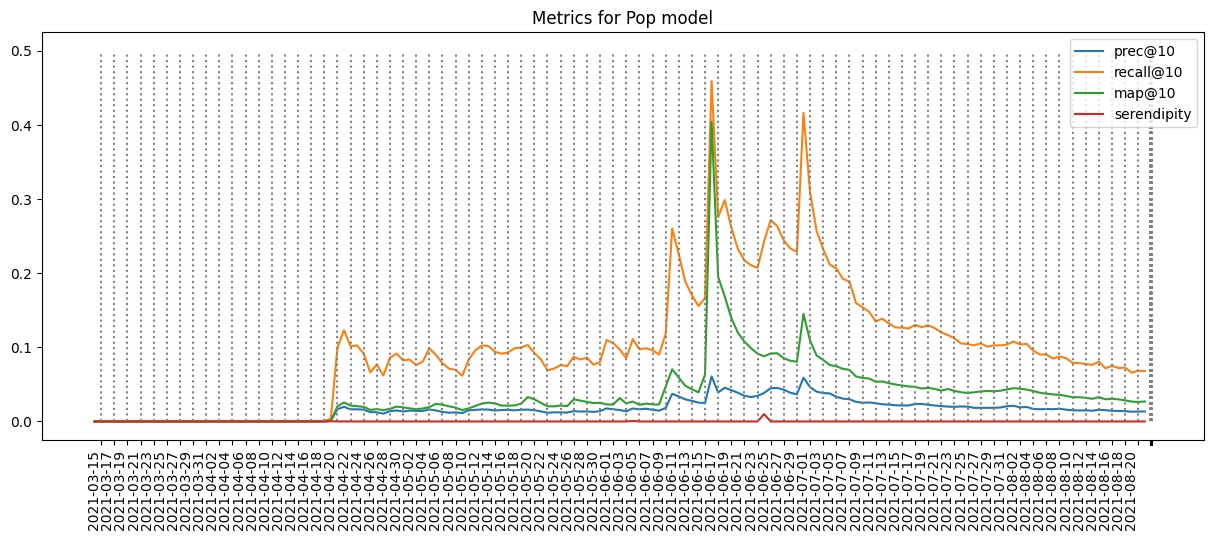

In [307]:
# make plot 

x_tick = calced_metrics_df.index.values.copy()
x_tick[::2] = ''

fig, ax = plt.subplots(figsize=(15,6))

ax = plt.plot(calced_metrics_df.drop(['novelty'],axis=1), )
plt.vlines(x_tick, ymin=0, ymax=0.5, linestyles=':', colors='grey')
plt.xticks(x_tick, )
fig.autofmt_xdate(rotation=90)
plt.legend(calced_metrics_df.drop(['novelty'],axis=1).columns)
plt.title('Metrics for Pop model')

plt.show()

In [313]:
# save the model
pickle.dump(simple_popular, open('../service/models/simple_popular.pickle', 'wb'))

In [314]:
loaded_model = pickle.load(open('../service/models/simple_popular.pickle', 'rb'))

In [316]:
loaded_model.recommend(
        X_test[Columns.User], 
        dataset=dataset, 
        k=10, 
        filter_viewed=False
    ).head()

,user_id,item_id,score,rank
0,106,10440,55181.0,1
1,106,9728,50629.0,2
2,106,15297,50588.0,3
3,106,13865,47553.0,4
4,106,4151,35645.0,5


## 3. Формирование оффлайн рекомендаций для всех пользователей

In [206]:
#TODO()

# 1) дополнить недостающие рекомендации горячих до 10 штук. Чем?
# 1.1) Можем попробовать докинуть популярные 
# 2) сформировать рекомендации для тёплых
# 3) сформировать рекомендации для холодных
# 2,3) Рекомендации для теплых и холодных -- это одна моделька